In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter, GammaGammaFitter

df = pd.read_csv('online_retail_II.csv')
#df.head()
#df.info()
#df.shape

In [2]:
#identify and drop rows with missing IDs
df.isnull().sum()
df = df.dropna(subset=['Customer ID'])
df["Customer ID"] = df["Customer ID"].astype(int)

In [3]:
#Remove top 0.05% transactions in terms of quantity if they were returned

qty_threshold = df["Quantity"].quantile(0.9995)
suspicious_df = df[df["Quantity"] > qty_threshold]

#suspicious_df = suspicious_df.sort_values(by='Quantity', ascending=True)
#suspicious_df.head(10)

indices_to_remove = []

for index, transaction in suspicious_df.iterrows():
    #Find transaction with same Customer ID, StockCode, and exact negative Quantity (likely a return/refund, etc.)
    matching_returns = df[
        (df['Customer ID'] == transaction['Customer ID']) &
        (df['StockCode'] == transaction['StockCode']) &
        (df['Quantity'] == -transaction['Quantity']) 
    ]
    
    if not matching_returns.empty:
        print(f"Purchase {transaction['Invoice']} (Qty: {transaction['Quantity']}) has a matching return")
        indices_to_remove.append(index)
        indices_to_remove.extend(matching_returns.index.tolist())
    else:
        print(f"Purchase {transaction['Invoice']} (Qty: {transaction['Quantity']}) has no matching return")

df_cleaned = df[~df.index.isin(indices_to_remove)].copy()
#print(f"Rows removed: {len(indices_to_remove)}")

Purchase 490018 (Qty: 4320) has no matching return
Purchase 490018 (Qty: 5184) has no matching return
Purchase 490018 (Qty: 4008) has no matching return
Purchase 490018 (Qty: 4008) has no matching return
Purchase 490785 (Qty: 936) has no matching return
Purchase 491133 (Qty: 1500) has no matching return
Purchase 491212 (Qty: 1002) has no matching return
Purchase 491440 (Qty: 1080) has no matching return
Purchase 491812 (Qty: 960) has no matching return
Purchase 491812 (Qty: 864) has no matching return
Purchase 492185 (Qty: 3000) has no matching return
Purchase 493722 (Qty: 1440) has no matching return
Purchase 493722 (Qty: 1080) has no matching return
Purchase 493799 (Qty: 832) has no matching return
Purchase 495194 (Qty: 6012) has no matching return
Purchase 495194 (Qty: 866) has no matching return
Purchase 495194 (Qty: 6144) has no matching return
Purchase 495194 (Qty: 2040) has no matching return
Purchase 495194 (Qty: 2520) has no matching return
Purchase 495194 (Qty: 3888) has no m

In [4]:
#Verify suspicious returned transactions are gone
df = df_cleaned.copy()
#df = df.sort_values(by='Quantity', ascending=False)
#print(df.head(10))

df = df[df['Quantity'] > 0]
df = df[df['Price'] > 0]

df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

df["Revenue"] = df["Quantity"] * df["Price"]

observation_end = df["InvoiceDate"].max()

In [5]:
print(observation_end)
print(type(observation_end))

2011-12-09 12:50:00
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [6]:
from lifetimes.utils import summary_data_from_transaction_data

summary = summary_data_from_transaction_data(
df, 
customer_id_col='Customer ID',
datetime_col='InvoiceDate',
monetary_value_col='Revenue',
observation_period_end=observation_end
)

summary.describe()

,frequency,recency,T,monetary_value
count,5878.000000,5878.00000,5878.000000,5878.000000
mean,4.631677,273.32409,474.260463,285.472809
std,9.999707,258.98387,223.090893,434.461842
min,0.000000,0.00000,0.000000,0.000000
25%,0.000000,0.00000,313.000000,0.000000
50%,2.000000,220.50000,530.000000,213.475100
75%,5.000000,512.00000,668.000000,376.052946
max,254.000000,738.00000,738.000000,9189.930455


In [7]:
first_purchase_map = df.groupby('Customer ID')['InvoiceDate'].min()
summary['first_purchase_date'] = summary.index.map(first_purchase_map)
summary['first_purchase_month'] = summary['first_purchase_date'].dt.to_period('M')

In [8]:
summary.head()

,frequency,recency,T,monetary_value,first_purchase_date,first_purchase_month
Customer ID,,,,,,
12346,6.0,196.0,725.0,47.143333,2009-12-14 08:34:00,2009-12
12347,7.0,402.0,404.0,717.398571,2010-10-31 14:20:00,2010-10
12348,4.0,363.0,438.0,449.310000,2010-09-27 14:59:00,2010-09
12349,3.0,571.0,589.0,1120.056667,2010-04-29 13:20:00,2010-04
12350,0.0,0.0,310.0,0.000000,2011-02-02 16:01:00,2011-02


In [9]:
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

summary["expected_purchases_30_days"] = bgf.conditional_expected_number_of_purchases_up_to_time(30, summary['frequency'], summary['recency'], summary['T'])

summary["probability_alive"] = bgf.conditional_probability_alive(summary['frequency'], summary['recency'], summary['T'])

In [10]:
#Check Do frequent buyers have higher expectations?
summary.sort_values("frequency", ascending=False).head()

,frequency,recency,T,monetary_value,first_purchase_date,first_purchase_month,expected_purchases_30_days,probability_alive
Customer ID,,,,,,,,
14911,254.0,737.0,738.0,1162.358268,2009-12-01 11:41:00,2009-12,9.520508,0.999601
12748,201.0,735.0,735.0,280.490000,2009-12-04 17:31:00,2009-12,7.567673,0.999633
15311,195.0,738.0,738.0,594.605846,2009-12-01 11:21:00,2009-12,7.314973,0.999622
17841,192.0,736.0,737.0,366.423490,2009-12-02 15:41:00,2009-12,7.211010,0.999511
14606,180.0,735.0,736.0,170.255889,2009-12-03 12:40:00,2009-12,6.770158,0.999486


In [11]:
#Check: Do recently active customers have higher prob_alive?
summary.sort_values("recency", ascending=False).head()

,frequency,recency,T,monetary_value,first_purchase_date,first_purchase_month,expected_purchases_30_days,probability_alive
Customer ID,,,,,,,,
17428,32.0,738.0,738.0,953.976875,2009-12-01 17:28:00,2009-12,1.218830,0.997713
15311,195.0,738.0,738.0,594.605846,2009-12-01 11:21:00,2009-12,7.314973,0.999622
18102,66.0,738.0,738.0,9189.930455,2009-12-01 09:24:00,2009-12,2.490429,0.998886
13394,18.0,737.0,738.0,350.953889,2009-12-01 11:58:00,2009-12,0.695148,0.995869
13777,45.0,737.0,737.0,1118.408889,2009-12-02 09:47:00,2009-12,1.707161,0.998369


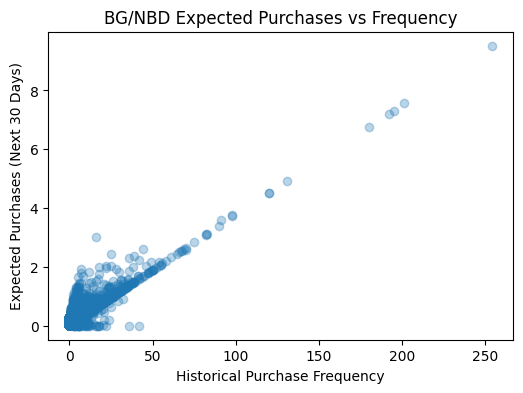

In [12]:
#Relationship between historical frequency and expected purchases

plt.figure(figsize=(6,4))
plt.scatter(
    summary["frequency"],
    summary["expected_purchases_30_days"],
    alpha=0.3
)
plt.xlabel("Historical Purchase Frequency")
plt.ylabel("Expected Purchases (Next 30 Days)")
plt.title("BG/NBD Expected Purchases vs Frequency")
plt.show()

<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

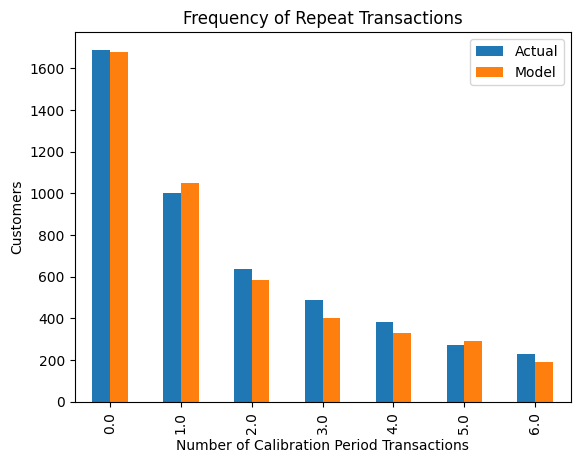

In [13]:
#Model simulation of entire window vs actual data counts

from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

In [14]:
#Prepare for Gamma-Gamma model, treat customers with frequency 0 as already churned
summary = summary[summary["frequency"] > 0].copy()
(summary["monetary_value"] <= 0).sum()

np.int64(0)

In [15]:
#Check for if monetary value is independent of frequency
summary[["frequency", "monetary_value"]].corr()

,frequency,monetary_value
frequency,1.000000,0.176485
monetary_value,0.176485,1.000000


In [16]:
#Predict how much customers will spend with Gamma-Gamma model

ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(summary['frequency'], summary['monetary_value'])

summary["expected_avg_monetary_value"] = ggf.conditional_expected_average_profit(summary['frequency'], summary['monetary_value'])


In [17]:
summary["expected_avg_monetary_value"].describe()

count     4188.000000
mean       432.998580
std        504.921017
min          9.196784
25%        208.956443
50%        330.164181
75%        482.463228
max      10096.316183
Name: expected_avg_monetary_value, dtype: float64

In [18]:
summary[["monetary_value", "expected_avg_monetary_value"]].head()

,monetary_value,expected_avg_monetary_value
Customer ID,,
12346,47.143333,49.195165
12347,717.398571,736.372268
12348,449.310000,470.874396
12349,1120.056667,1190.897470
12352,338.261250,346.313029


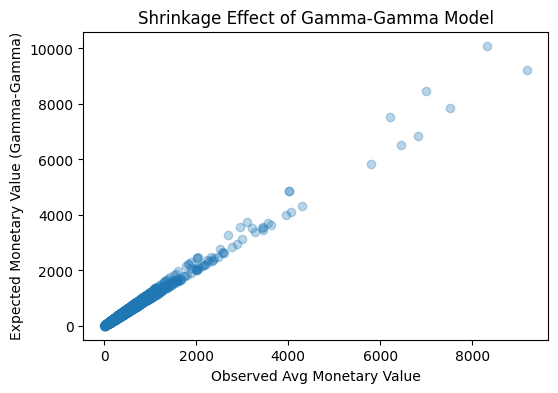

In [19]:
plt.figure(figsize=(6,4))
plt.scatter(
    summary["monetary_value"],
    summary["expected_avg_monetary_value"],
    alpha=0.3
)
plt.xlabel("Observed Avg Monetary Value")
plt.ylabel("Expected Monetary Value (Gamma-Gamma)")
plt.title("Shrinkage Effect of Gamma-Gamma Model")
plt.show()


In [20]:
minimum_date = df["InvoiceDate"].min()
#print(minimum_date)
#observation_end
maximum_date = df["InvoiceDate"].max()
#print(maximum_date)
days_diff = (maximum_date - minimum_date).days
#print(days_diff)
cutoff = 0.75*days_diff
#print(cutoff)
delta = days_diff - cutoff
#print(delta)
delta = int(delta)
calibration_end_date = maximum_date - timedelta(days=delta)
print(calibration_end_date)

2011-06-08 12:50:00


In [21]:
from lifetimes.utils import calibration_and_holdout_data


summary_cal_holdout = calibration_and_holdout_data(
    df,
    customer_id_col='Customer ID',
    datetime_col='InvoiceDate',
    monetary_value_col='Revenue',
    calibration_period_end=calibration_end_date,
    observation_period_end=observation_end
)

#BG/NBD with calibration

bgf_cal = BetaGeoFitter(penalizer_coef=0.001)
bgf_cal.fit(
    summary_cal_holdout['frequency_cal'],
    summary_cal_holdout['recency_cal'],
    summary_cal_holdout['T_cal']
)


#Predict purchases in holdout
t_holdout = summary_cal_holdout['duration_holdout']

summary_cal_holdout['predicted_purchases'] = bgf_cal.predict(
    t_holdout,
    summary_cal_holdout['frequency_cal'],
    summary_cal_holdout['recency_cal'],
    summary_cal_holdout['T_cal']
)


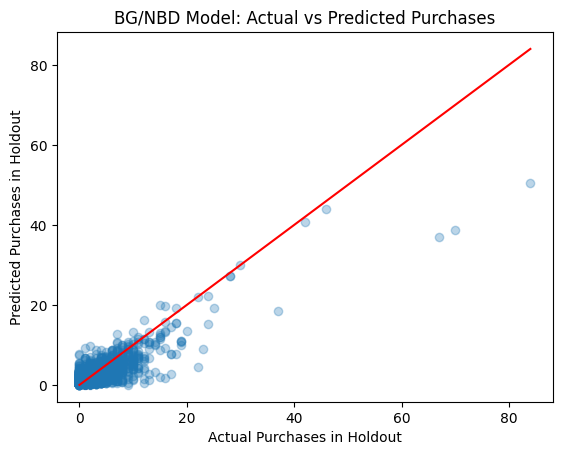

In [22]:
#Aggregate validation

summary_cal_holdout['frequency_holdout'].sum()
summary_cal_holdout['predicted_purchases'].sum()

summary_cal_holdout['abs_error'] = np.abs(
    summary_cal_holdout['frequency_holdout'] - summary_cal_holdout['predicted_purchases']
)

#summary_cal_holdout['abs_error'].mean()

plt.scatter(
    summary_cal_holdout['frequency_holdout'],
    summary_cal_holdout['predicted_purchases'],
    alpha=0.3
)

plt.plot([0, max(summary_cal_holdout['frequency_holdout'])],
         [0, max(summary_cal_holdout['frequency_holdout'])],
         color='red')

plt.xlabel("Actual Purchases in Holdout")
plt.ylabel("Predicted Purchases in Holdout")
plt.title("BG/NBD Model: Actual vs Predicted Purchases")
plt.show()

In [23]:
#print absolute error
print("Mean Absolute Error:", summary_cal_holdout['abs_error'].mean())

Mean Absolute Error: 1.0525332687808753


<Axes: title={'center': 'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

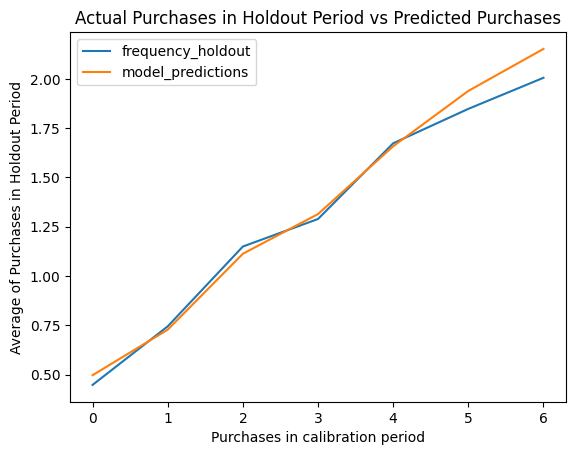

In [24]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

plot_calibration_purchases_vs_holdout_purchases(bgf_cal, summary_cal_holdout)

In [25]:
summary.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4188 entries, 12346 to 18287
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   frequency                    4188 non-null   float64       
 1   recency                      4188 non-null   float64       
 2   T                            4188 non-null   float64       
 3   monetary_value               4188 non-null   float64       
 4   first_purchase_date          4188 non-null   datetime64[ns]
 5   first_purchase_month         4188 non-null   period[M]     
 6   expected_purchases_30_days   4188 non-null   float64       
 7   probability_alive            4188 non-null   float64       
 8   expected_avg_monetary_value  4188 non-null   float64       
dtypes: datetime64[ns](1), float64(7), period[M](1)
memory usage: 327.2 KB


In [26]:
from lifetimes.utils import summary_data_from_transaction_data


discount_rate = 0.01  # 1% monthly discount rate
time_horizon = 12  # months

# Calculate 12 month CLV

summary['clv'] = ggf.customer_lifetime_value(
    bgf,
    summary['frequency'],
    summary['recency'],
    summary['T'],
    summary['monetary_value'],
    time=time_horizon,
    discount_rate=discount_rate,
    freq='M'  
)

In [27]:
#expected purchases in 12 months
#expected monetary value in 12 months

summary['expected_purchases_12_months'] = bgf.predict(
    time_horizon,
    summary['frequency'],
    summary['recency'],
    summary['T'],
)

summary['approx_clv'] = (
    summary['expected_purchases_12_months'] *
    summary['expected_avg_monetary_value']
)

In [52]:
#how often they'll buy
#how much they'll spend


summary['purchase_frequency_segment'] = pd.qcut(
    summary['expected_purchases_12_months'],
    q=4,
    labels=['Low', 'Medium', 'High', 'Very High']
)


summary['monetary_value_segment'] = pd.qcut(
    summary['expected_avg_monetary_value'],
    q=4,
    labels=['Low', 'Medium', 'High', 'Very High']
)


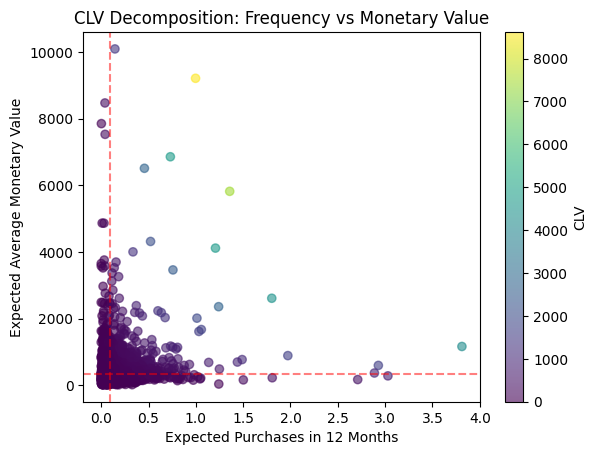

In [29]:
freq_threshold = summary['expected_purchases_12_months'].median()
monetary_threshold = summary['expected_avg_monetary_value'].median()

plt.scatter(
    summary['expected_purchases_12_months'],
    summary['expected_avg_monetary_value'],
    c=summary['clv'],
    cmap = 'viridis',
    alpha=0.6
)

plt.axvline(x=freq_threshold, color='red', linestyle='--', alpha=0.5)
plt.axhline(y=monetary_threshold, color='red', linestyle='--', alpha=0.5)

plt.colorbar(label='CLV')
plt.xlabel("Expected Purchases in 12 Months")
plt.ylabel("Expected Average Monetary Value")
plt.title("CLV Decomposition: Frequency vs Monetary Value")
plt.show()

In [38]:
# Define quartile thresholds
freq_q25 = summary['expected_purchases_12_months'].quantile(0.25)
freq_q50 = summary['expected_purchases_12_months'].quantile(0.50)
freq_q75 = summary['expected_purchases_12_months'].quantile(0.75)

monetary_q25 = summary['expected_avg_monetary_value'].quantile(0.25)
monetary_q50 = summary['expected_avg_monetary_value'].quantile(0.50)
monetary_q75 = summary['expected_avg_monetary_value'].quantile(0.75)

def assign_segment(row):
    # Classify frequency
    if row['expected_purchases_12_months'] >= freq_q75:
        freq_label = 'Very High'
    elif row['expected_purchases_12_months'] >= freq_q50:
        freq_label = 'High'
    elif row['expected_purchases_12_months'] >= freq_q25:
        freq_label = 'Medium'
    else:
        freq_label = 'Low'
    
    # Classify monetary value
    if row['expected_avg_monetary_value'] >= monetary_q75:
        mon_label = 'Very High'
    elif row['expected_avg_monetary_value'] >= monetary_q50:
        mon_label = 'High'
    elif row['expected_avg_monetary_value'] >= monetary_q25:
        mon_label = 'Medium'
    else:
        mon_label = 'Low'
    
    return f'{freq_label} Frequency & {mon_label} Value'

# Create the new column
summary['segment'] = summary.apply(assign_segment, axis=1)

# See the average CLV and count of each segment
segment_analysis = summary.groupby('segment').agg({
    'clv': ['mean', 'sum', 'count'],
    'probability_alive': 'mean'
}).round(2)

print(segment_analysis)

                                          clv                   \
                                         mean        sum count   
segment                                                          
High Frequency & High Value             47.22   13269.70   281   
High Frequency & Low Value              17.42    3848.97   221   
High Frequency & Medium Value           31.45    8680.06   276   
High Frequency & Very High Value       102.86   27668.08   269   
Low Frequency & High Value              10.06    2293.03   228   
Low Frequency & Low Value                3.22    1079.09   335   
Low Frequency & Medium Value             6.44    1475.41   229   
Low Frequency & Very High Value         23.52    5998.26   255   
Medium Frequency & High Value           23.68    5896.93   249   
Medium Frequency & Low Value             8.64    2677.40   310   
Medium Frequency & Medium Value         16.18    4223.69   261   
Medium Frequency & Very High Value      50.98   11573.47   227   
Very High 

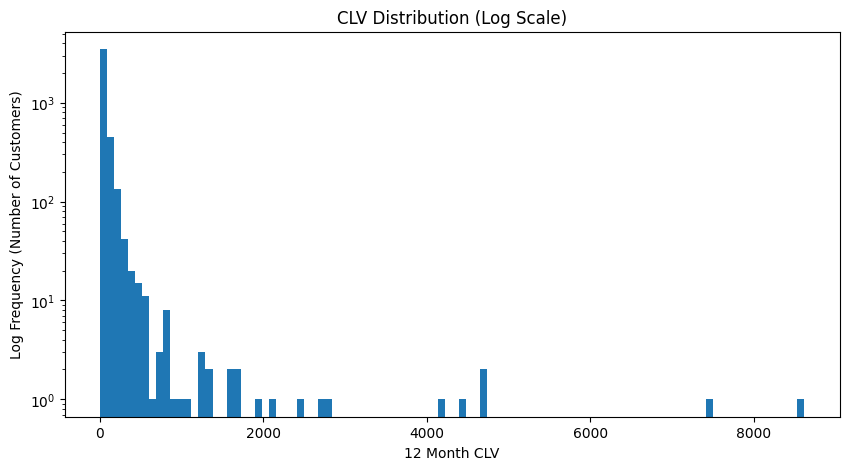

In [31]:
plt.figure(figsize=(10, 5))
summary['clv'].plot(kind='hist', bins=100)
plt.yscale('log') # This allows you to see the small number of high-value customers
plt.xlabel('12 Month CLV')
plt.ylabel('Log Frequency (Number of Customers)')
plt.title('CLV Distribution (Log Scale)')
plt.show()

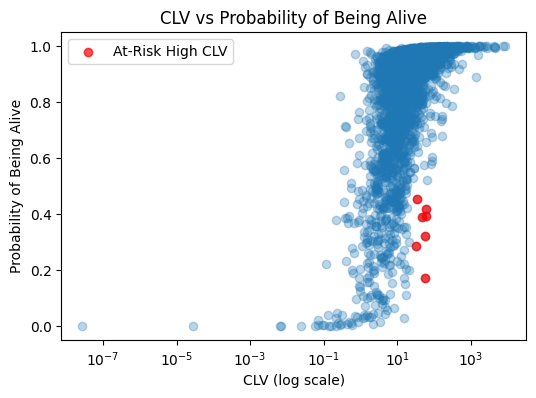

In [32]:
#identifies most at-risk high CLV customers


at_risk = summary[
    (summary['clv'] > summary['clv'].quantile(0.5)) &
    (summary['probability_alive'] < 0.5)
]

#scatter CLV vs probability alive

plt.figure(figsize=(6,4))
plt.scatter(summary['clv'], summary['probability_alive'], alpha=0.3)
plt.scatter(at_risk['clv'], at_risk['probability_alive'], alpha=0.7, color='red', label='At-Risk High CLV')
plt.xscale('log')
plt.xlabel('CLV (log scale)')
plt.ylabel('Probability of Being Alive')
plt.title('CLV vs Probability of Being Alive')
plt.legend()
plt.show()


In [33]:
#Where does long term revenue come from
summary[['expected_purchases_12_months', 'expected_avg_monetary_value', 'clv']].corr()

#CLV vs frequency and monetary value are both positively correlated and nearly identical, but monetary value has a slightly stronger correlation with CLV. Gamma-Gamma assumption that they are indepnedent is validated. Frequent fliers are equally as critically as big spenders.

,expected_purchases_12_months,expected_avg_monetary_value,clv
expected_purchases_12_months,1.000000,0.124341,0.533093
expected_avg_monetary_value,0.124341,1.000000,0.556918
clv,0.533093,0.556918,1.000000


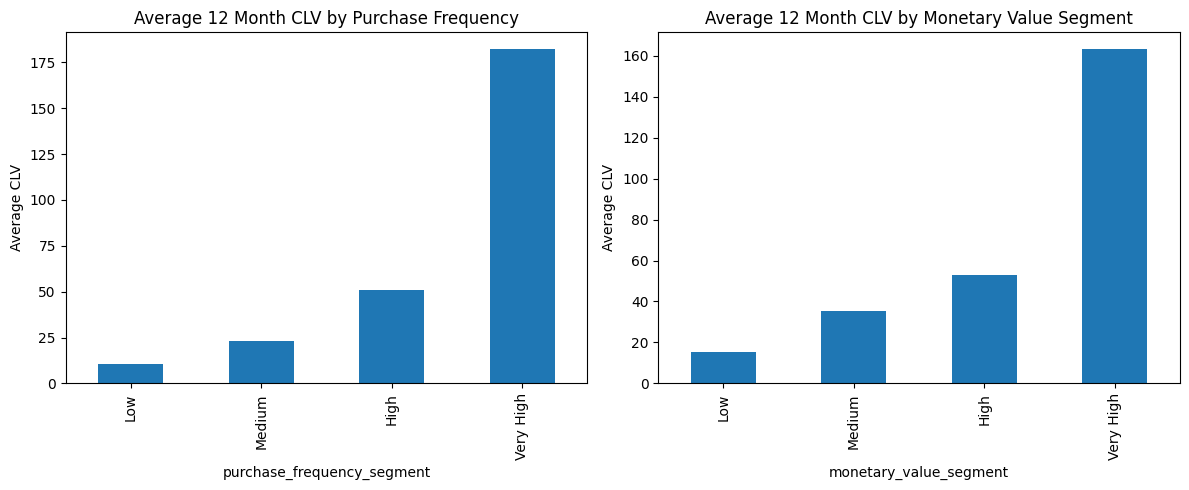

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

summary.groupby('purchase_frequency_segment')['clv'].mean().plot(kind='bar', ax=ax[0], title='Average CLV by Purchase Intensity')
ax[0].set_title('Average 12 Month CLV by Purchase Frequency')
ax[0].set_ylabel('Average CLV')

summary.groupby('monetary_value_segment')['clv'].mean().plot(kind='bar', ax=ax[1], title='Average CLV by Monetary Value Segment')
ax[1].set_title('Average 12 Month CLV by Monetary Value Segment')
ax[1].set_ylabel('Average CLV')

plt.tight_layout()
plt.show()

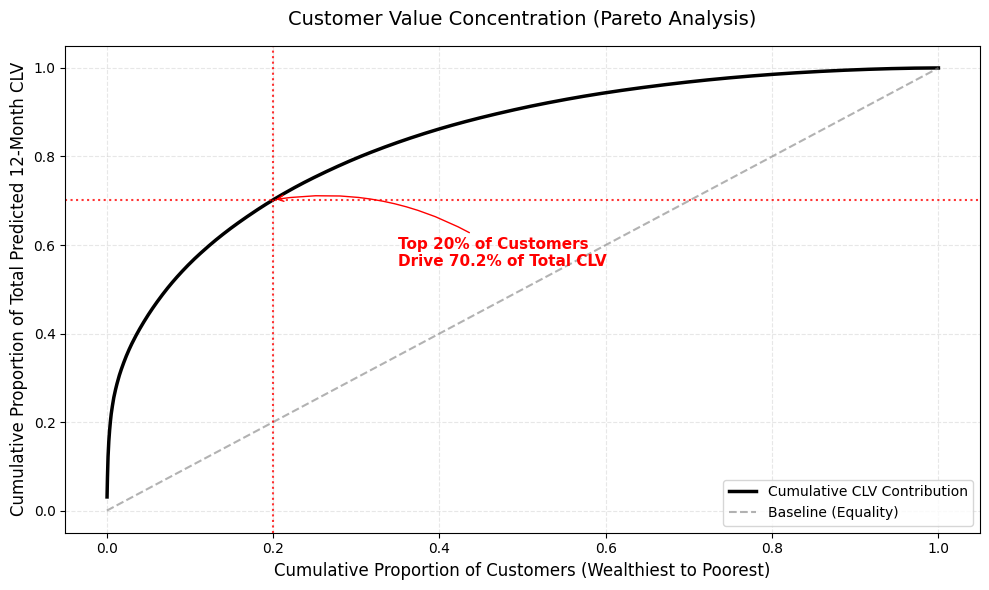

In [35]:
summary_sorted = summary.sort_values('clv', ascending=False).reset_index(drop=True)


summary_sorted['cum_clv_pct'] = summary_sorted['clv'].cumsum() / summary_sorted['clv'].sum()
summary_sorted['cum_customer_pct'] = (summary_sorted.index + 1) / len(summary_sorted)

plt.figure(figsize=(10, 6))

#Lorenz Curve
plt.plot(summary_sorted['cum_customer_pct'], summary_sorted['cum_clv_pct'], 
         label='Cumulative CLV Contribution', color="#000000", lw=2.5)

#Perfect Equality line  where every customer spends the exact same amount.
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', alpha=0.6, label='Baseline (Equality)')

# 4. Highlight the Pareto Principle (Top 20% of Customers)
top_20_cutoff = 0.20
top_20_revenue_pct = summary_sorted.iloc[int(len(summary_sorted) * top_20_cutoff)]['cum_clv_pct']

plt.axvline(x=top_20_cutoff, color='red', linestyle=':', alpha=0.8)
plt.axhline(y=top_20_revenue_pct, color='red', linestyle=':', alpha=0.8)

plt.annotate(f'Top 20% of Customers\nDrive {top_20_revenue_pct:.1%} of Total CLV', 
             xy=(top_20_cutoff, top_20_revenue_pct), 
             xytext=(0.35, top_20_revenue_pct - 0.15),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2', color='red'),
             fontsize=11, fontweight='bold', color='red')

plt.title('Customer Value Concentration (Pareto Analysis)', fontsize=14, pad=15)
plt.xlabel('Cumulative Proportion of Customers (Wealthiest to Poorest)', fontsize=12)
plt.ylabel('Cumulative Proportion of Total Predicted 12-Month CLV', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True, which='both', linestyle='--', alpha=0.3)
plt.tight_layout()

plt.show()

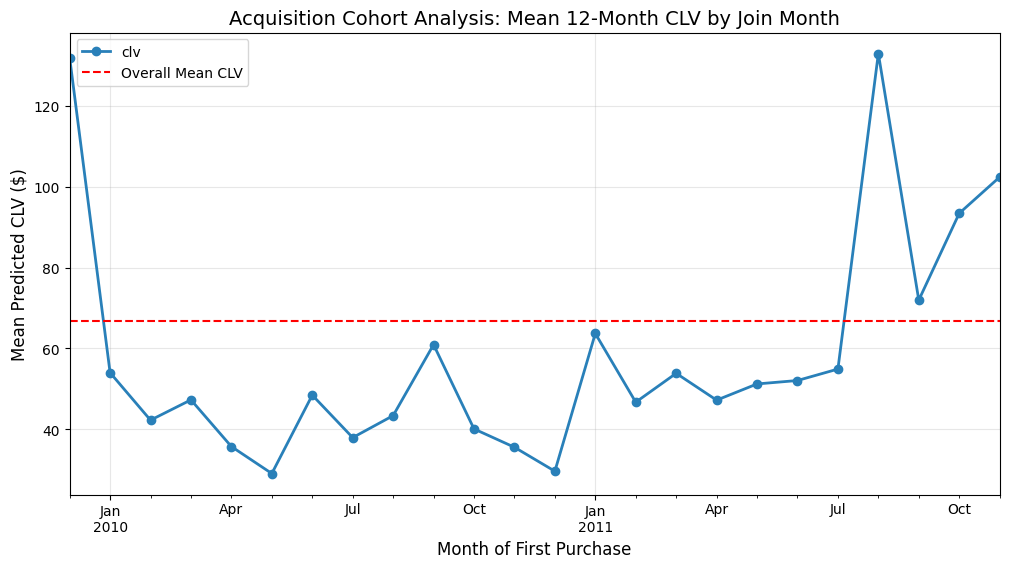

In [36]:
#are we acquiring high CLV customers over time?
#line plot of average CLV by cohort month

cohort_clv = summary.groupby('first_purchase_month')['clv'].mean()

plt.figure(figsize=(12, 6))
# Convert period to timestamp for easier plotting
cohort_clv.index = cohort_clv.index.to_timestamp()

cohort_clv.plot(marker='o', linestyle='-', color='#2980b9', linewidth=2)

plt.title('Acquisition Cohort Analysis: Mean 12-Month CLV by Join Month', fontsize=14)
plt.xlabel('Month of First Purchase', fontsize=12)
plt.ylabel('Mean Predicted CLV ($)', fontsize=12)
plt.grid(True, alpha=0.3)

# Optional: Add a horizontal line for the overall average to see which months were "above par"
plt.axhline(summary['clv'].mean(), color='red', linestyle='--', label='Overall Mean CLV')
plt.legend()

plt.show()

In [56]:
summary.head()

,frequency,recency,T,monetary_value,first_purchase_date,first_purchase_month,expected_purchases_30_days,probability_alive,expected_avg_monetary_value,clv,expected_purchases_12_months,approx_clv,monetary_value_segment,segment,purchase_frequency_segment
Customer ID,,,,,,,,,,,,,,,
12346,6.0,196.0,725.0,47.143333,2009-12-14 08:34:00,2009-12,0.012251,0.048356,49.195165,0.226305,0.004905,0.241280,Low,Low Frequency & Low Value,Low
12347,7.0,402.0,404.0,717.398571,2010-10-31 14:20:00,2010-10,0.485998,0.989553,736.372268,134.459940,0.194679,143.356465,Very High,Very High Frequency & Very High Value,Very High
12348,4.0,363.0,438.0,449.310000,2010-09-27 14:59:00,2010-09,0.268655,0.964144,470.874396,47.526126,0.107610,50.670730,High,High Frequency & High Value,High
12349,3.0,571.0,589.0,1120.056667,2010-04-29 13:20:00,2010-04,0.164144,0.975301,1190.897470,73.417745,0.065728,78.275804,Very High,Medium Frequency & Very High Value,Medium
12352,8.0,356.0,392.0,338.261250,2010-11-12 10:20:00,2010-11,0.559561,0.982000,346.313029,72.809897,0.224154,77.627323,High,Very High Frequency & High Value,Very High


In [ ]:
#rename customer ID column to snake case for db upload
summary = summary.rename(columns={'Customer ID': 'customer_id'})


In [66]:
summary['customer_id'] = summary['customer_id'].astype(str)
df['customer_id'] = df['customer_id'].astype(str)


In [65]:
print(df.columns.tolist())

['invoice', 'stock_code', 'description', 'quantity', 'invoice_date', 'price', 'customer_id', 'country', 'revenue']


In [73]:
summary['first_purchase_month'] = summary['first_purchase_month'].astype(str)

In [83]:
summary["customer_id"] = summary["customer_id"].astype(int)

float_cols = [
    "frequency", "recency", "T", "monetary_value",
    "expected_purchases_30_days", "probability_alive",
    "expected_avg_monetary_value", "clv",
    "expected_purchases_12_months", "approx_clv"
]

summary[float_cols] = summary[float_cols].astype(float)

str_cols = [
    "first_purchase_date", "first_purchase_month",
    "monetary_value_segment", "purchase_frequency_segment", "segment"
]

summary[str_cols] = summary[str_cols].astype(str)


In [84]:
import sqlite3

conn = sqlite3.connect("app.db")

In [85]:
summary.to_sql(
    "customer_summary",
    conn,
    if_exists="replace",
    index=False
)

4188

In [86]:
cursor = conn.cursor()

cursor.execute("""
CREATE INDEX idx_customer_id
ON customer_summary (customer_id);
""")

cursor.execute("""
CREATE INDEX idx_segment
ON customer_summary (segment);
""")

conn.commit()
conn.close()
